# Convolutional Neural Networks (PyTorch)

In this assignment, we will use Convolutional Neural Networks (CNNs) to design an end-to-end system for face classification/identification. Our system will be given an image as input and will output the ID/name of the person shown in that image. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import os 
import pathlib
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [2]:
#checking for device
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
#set paths 
training_dataset_path = "./HW3_Data/HW4_Data/classification_data/train_data"
testing_dataset_path = "./HW3_Data/HW4_Data/classification_data/test_data"
validation_dataset_path = "./HW3_Data/HW4_Data/classification_data/val_data"

## Get the mean and std

In [5]:
#transform to get the mean and std
training_transforms = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        ])

In [6]:
train_dataset = datasets.ImageFolder(root = training_dataset_path,transform =training_transforms)

In [7]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 1000, shuffle = True)

In [8]:
def get_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images_count = 0
    for batch, _ in loader:
        images_in_batch = batch.size(0)
        batch = batch.view(images_in_batch, batch.size(1),-1)
        mean += batch.mean(2).sum(0)
        std += batch.std(2).sum(0)
        total_images_count += images_in_batch
    
    mean /= total_images_count
    std /= total_images_count

    return mean ,std 

In [9]:
# mean ,std = get_mean_std(train_loader)
mean ,std = torch.tensor([0.4831, 0.4053, 0.3707]), torch.tensor([0.2573, 0.2337, 0.2276])
print(mean, std)

tensor([0.4831, 0.4053, 0.3707]) tensor([0.2573, 0.2337, 0.2276])


## Transforms and loading the data

In [10]:
training_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomRotation(20),
    transforms.RandomCrop(64, padding = 2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),torch.Tensor(std)),
    ])


testing_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),torch.Tensor(std)),
    ])

In [11]:
train_dataset = datasets.ImageFolder(root = training_dataset_path, transform = training_transforms)
valid_dataset = datasets.ImageFolder(root = validation_dataset_path, transform = testing_transforms)
test_dataset = datasets.ImageFolder(root = testing_dataset_path, transform = testing_transforms)

## Visualize the data

In [12]:
def plot_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size= 6, shuffle= True)
    batch = next (iter (loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(64,64))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print("labels",labels)  
    

### Before preprocessing 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels tensor([2696, 1537, 3869, 3249, 3749, 1819])


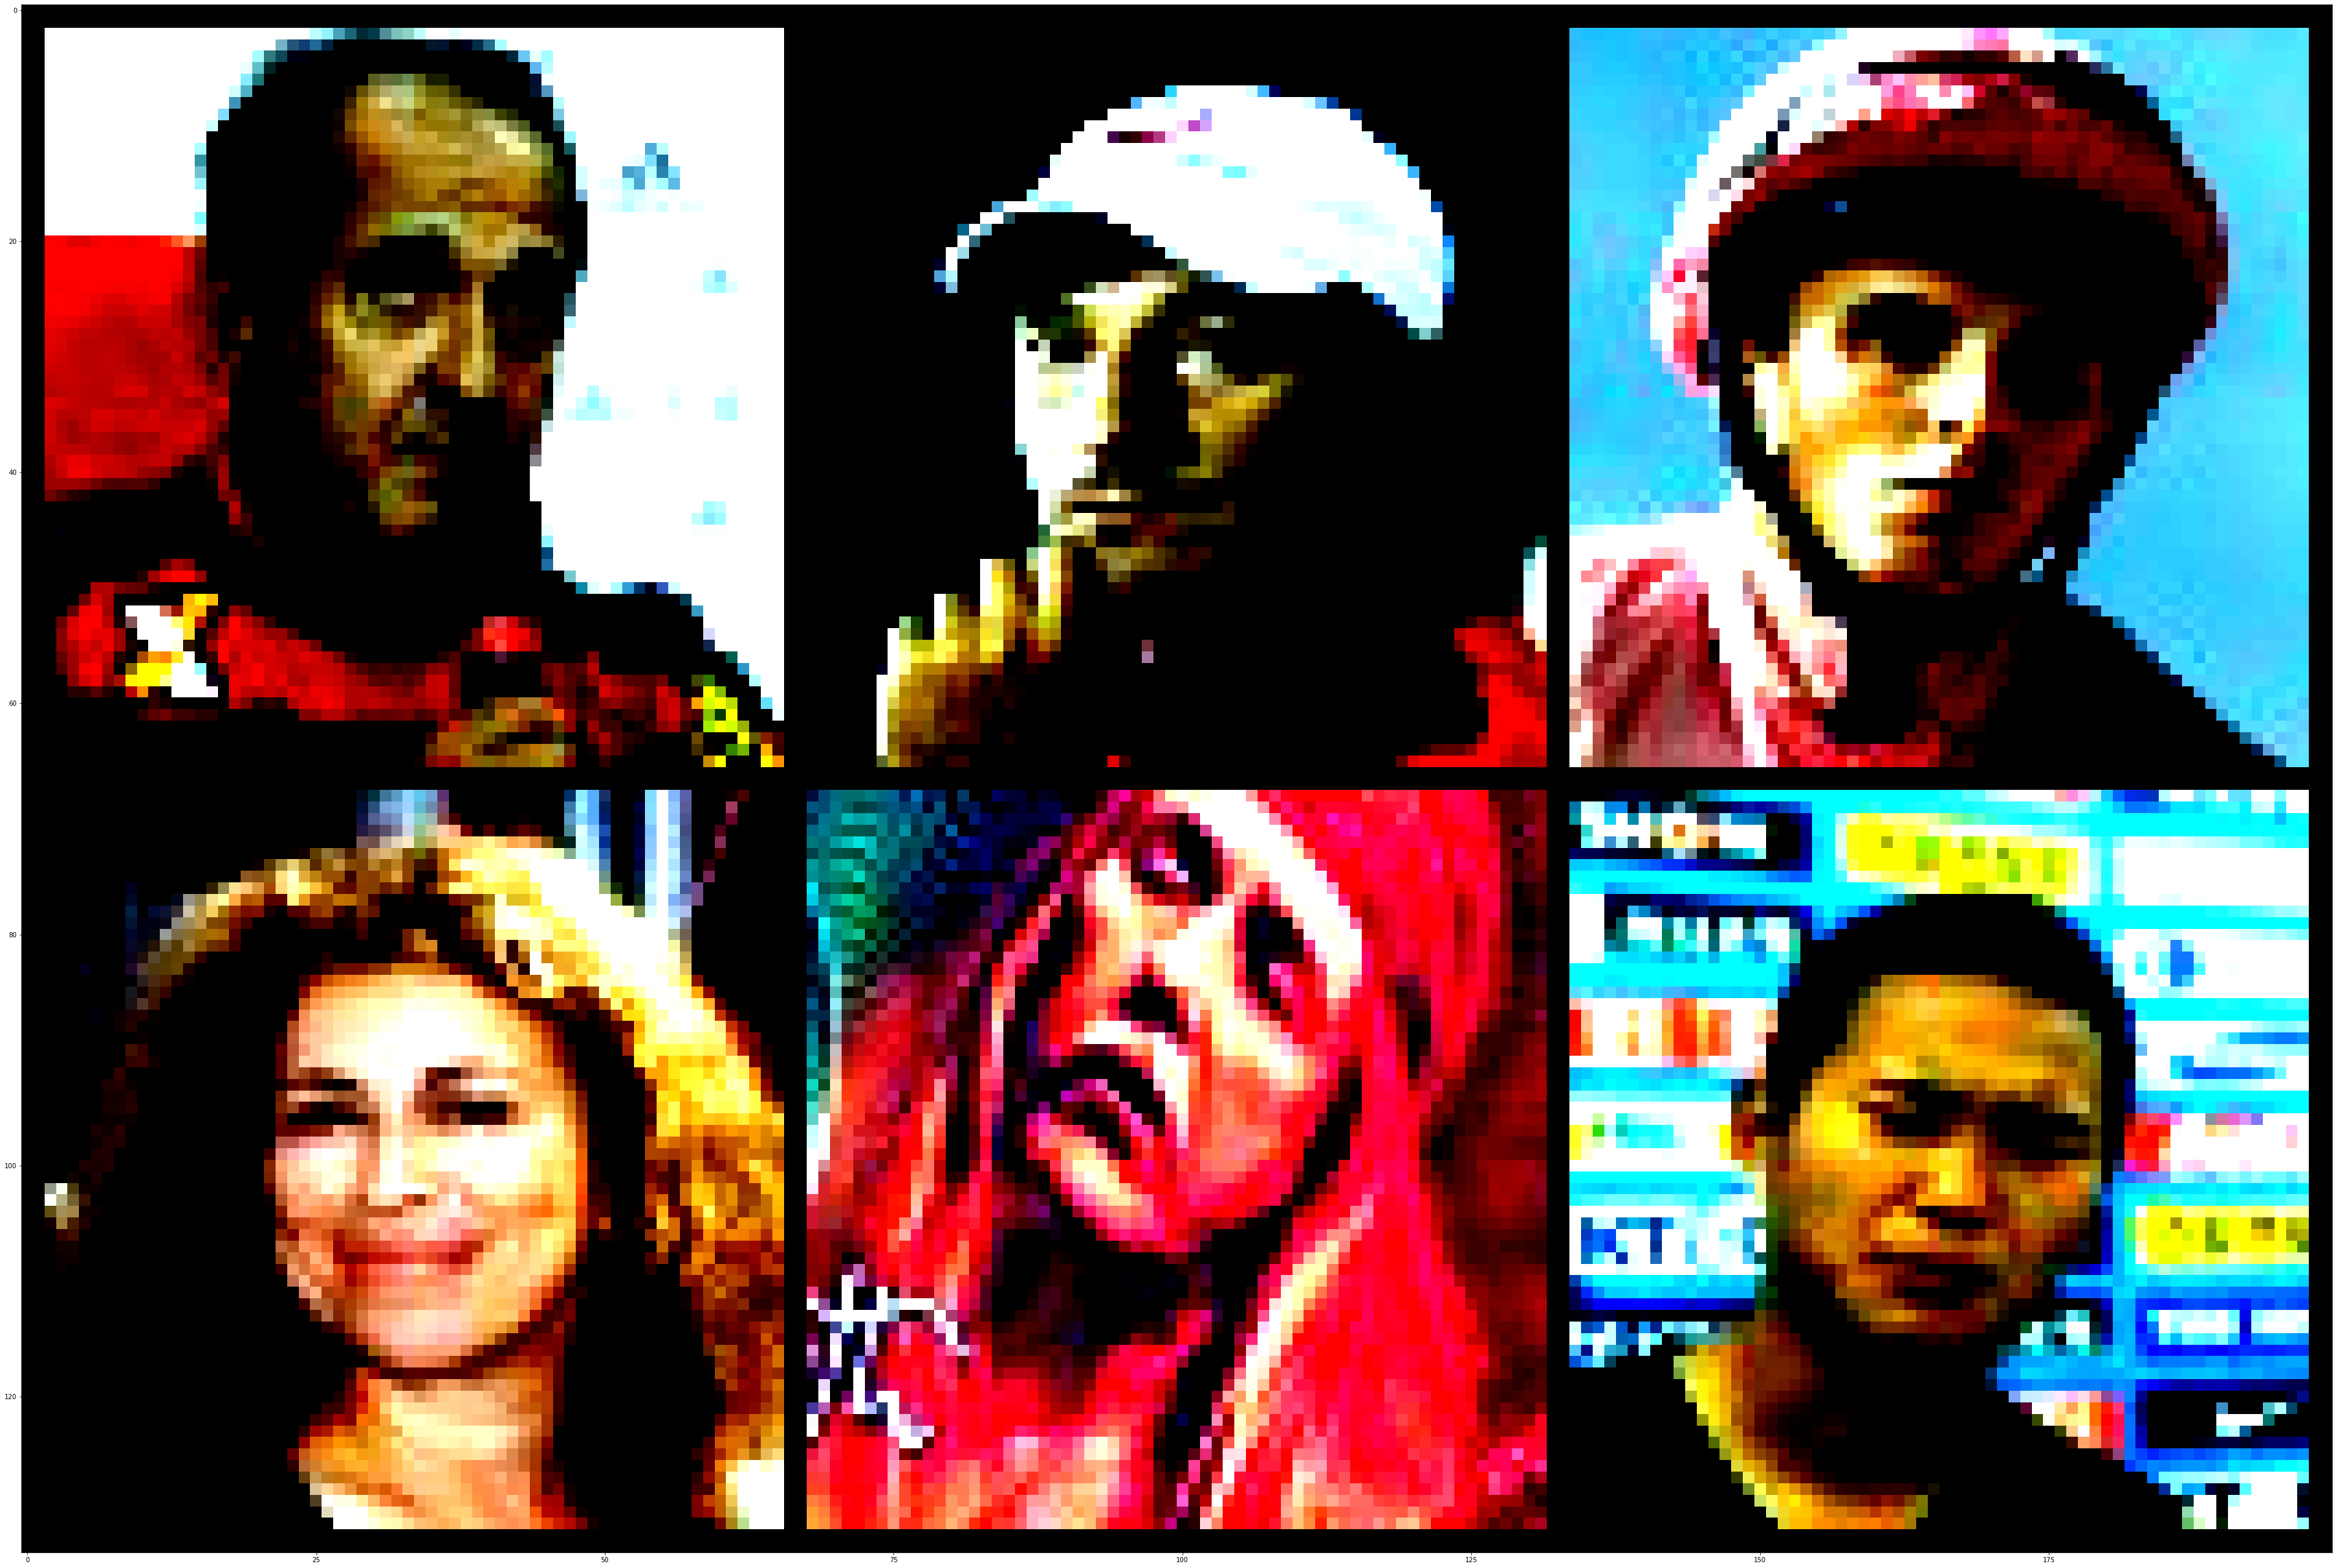

In [13]:
plot_images(valid_dataset)

### After preprocessing 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels tensor([3652,  152, 1596,  953,  929,  336])


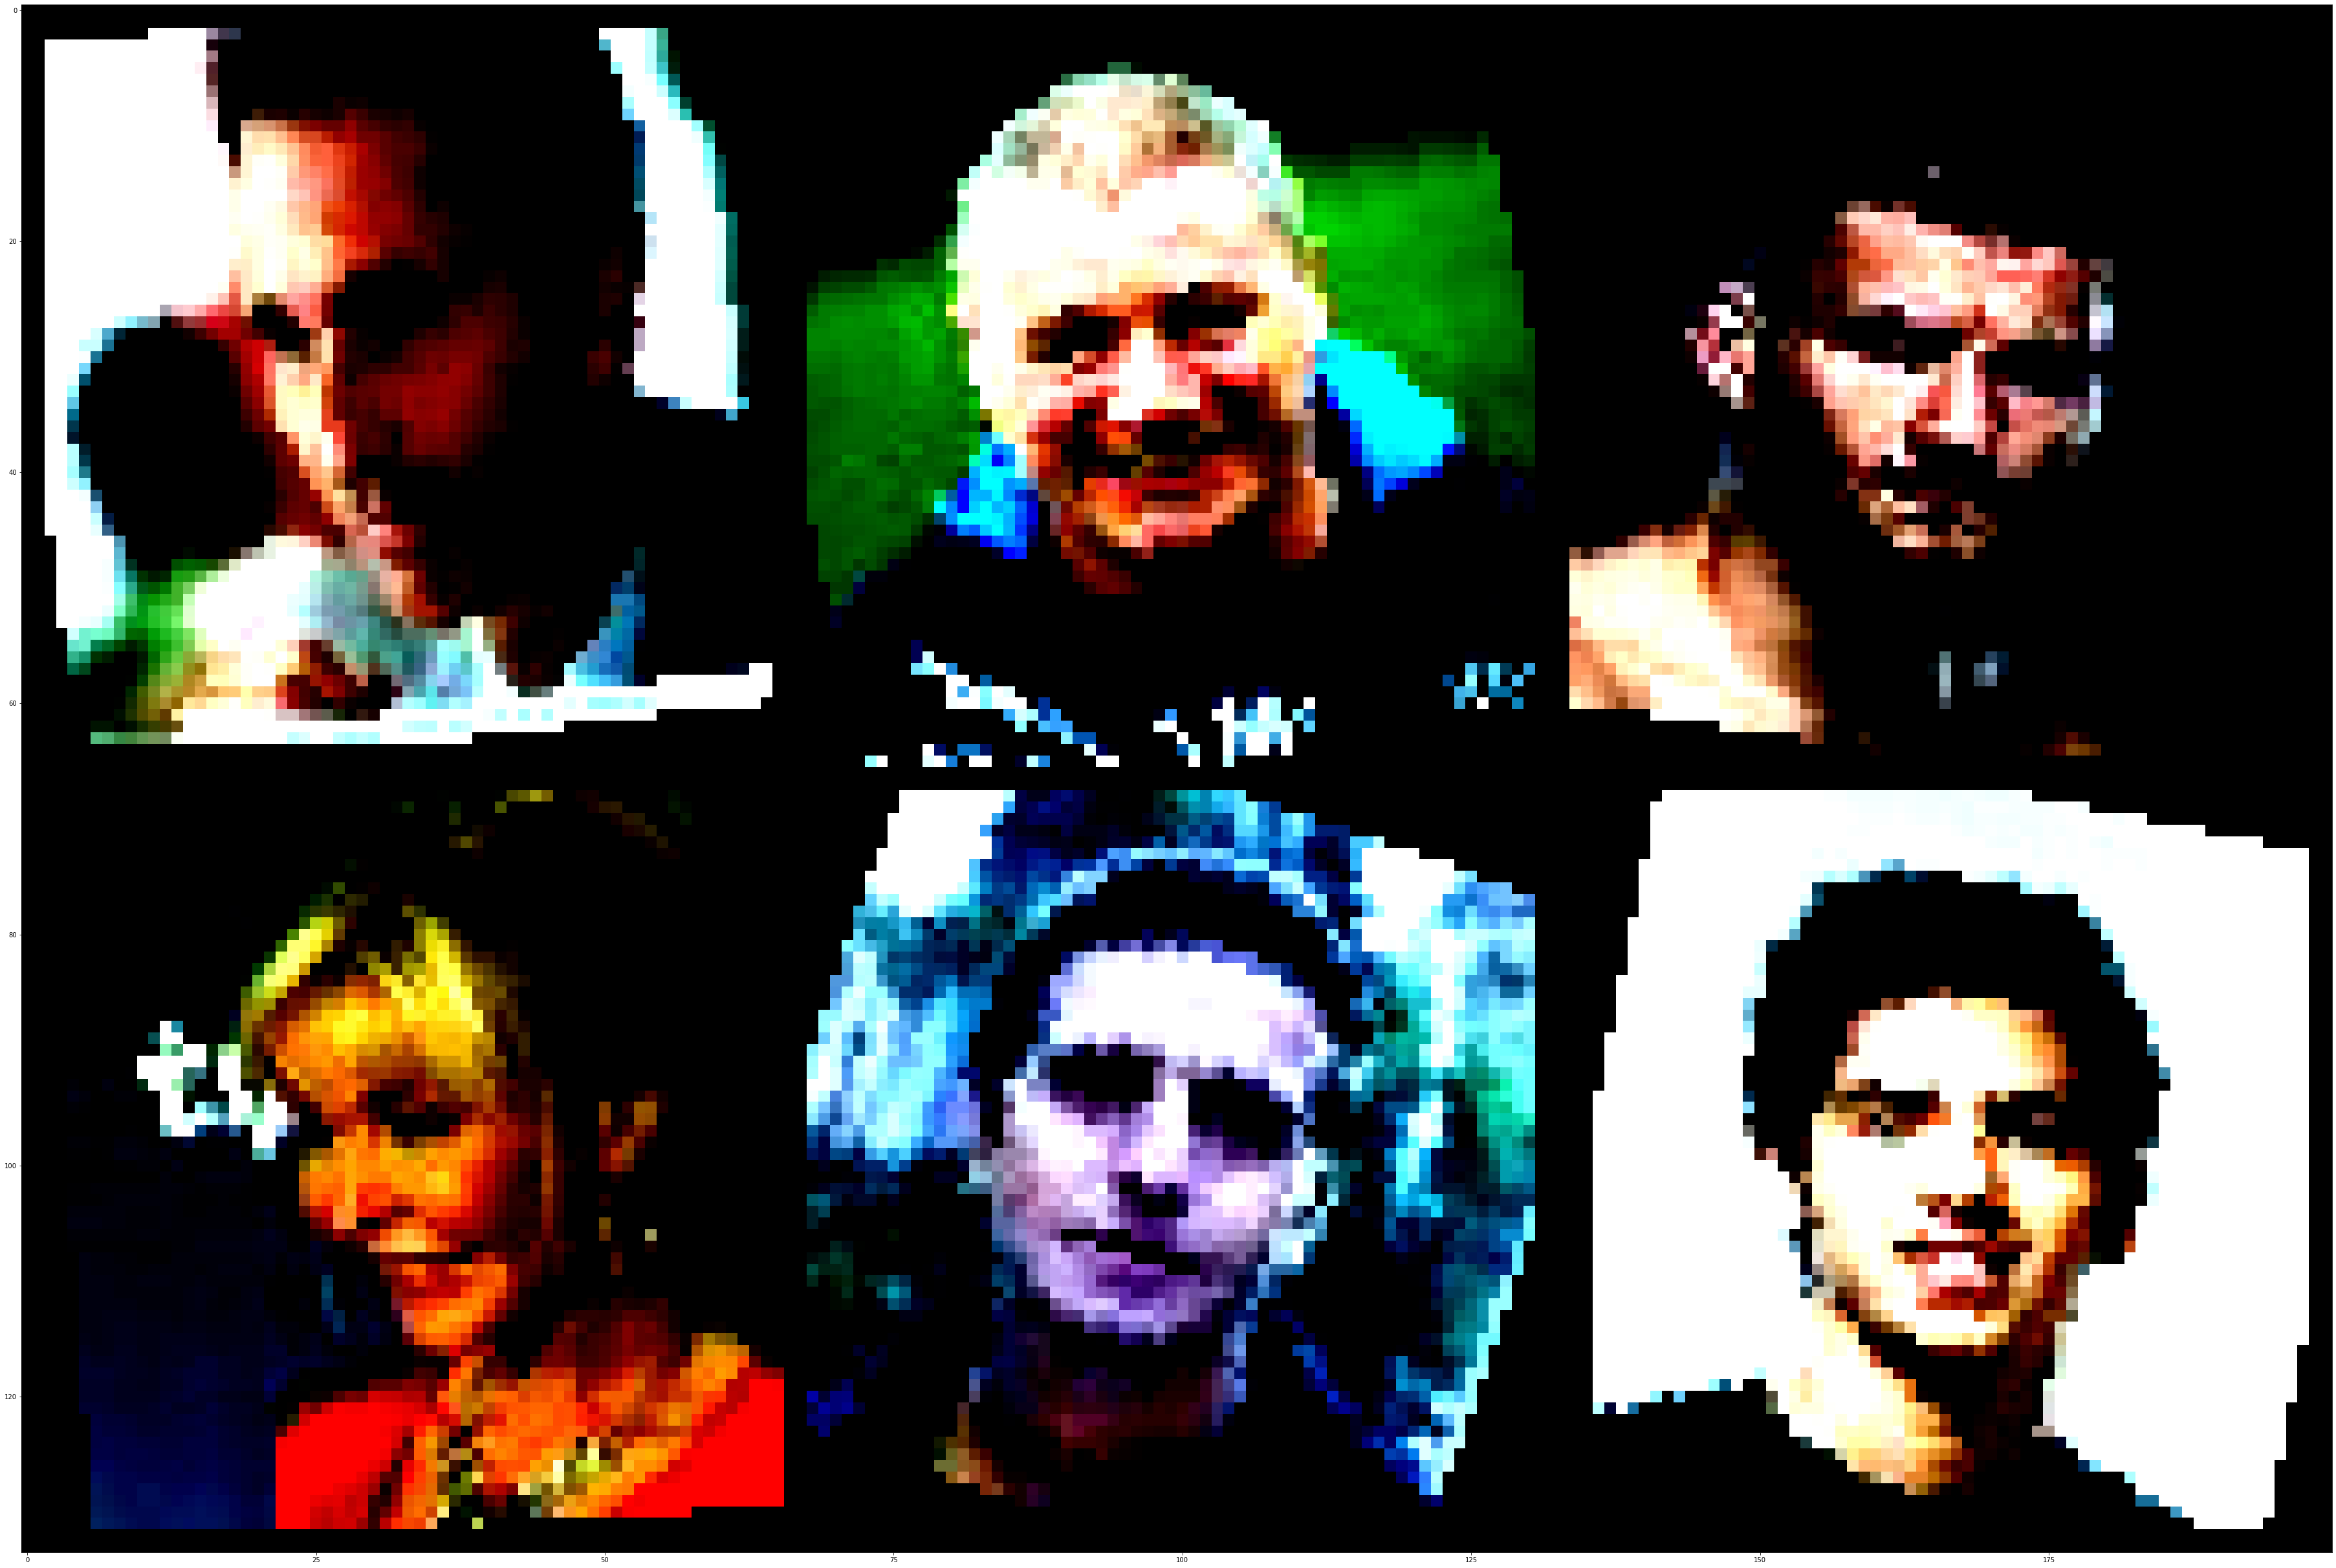

In [14]:
plot_images(train_dataset)

In [15]:
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of validation examples: {len(valid_dataset)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 380638
Number of validation examples: 8000
Number of testing examples: 8000


## Architecture 

In [16]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()

        #input shape = (batch_size,3,64,64)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(7,7), stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(7,7), stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5,5), stride=1)
        self.drop = nn.Dropout2d(p=0.5)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels= 16, kernel_size=(5,5), stride=1, padding=0)
        self.batch = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(5184, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.drop(x)
        x = F.relu(self.conv4(x))
        x = self.batch(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x) 

        return x


# model = ConvNet()
# x = torch.randn(64, 3, 64, 64)
# print(model(x).shape)
# exit()

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [19]:
def train(model, data_iterator, optimizer, loss_function, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in data_iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred= model(x)
        
        loss = loss_function(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    avg_loss = epoch_loss / len(data_iterator)
    avg_acc  = epoch_acc / len(data_iterator)     
    
    return avg_loss, avg_acc

In [20]:
def evaluate(model, data_iterator, loss_function, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in data_iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = loss_function(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    avg_loss = epoch_loss / len(data_iterator)
    avg_acc  = epoch_acc / len(data_iterator)     

    return avg_loss, avg_acc

In [21]:
### VISUALIZATION ###
def plot_curves(a, b, label):
    plt.figure(1)
    plt.plot(a, 'b', label="train")
    plt.plot(b, 'g', label="valid")
    plt.title('Training/Valid ' + label)
    plt.legend()
    plt.show()

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [23]:
def main(model, train_iterator,valid_iterator, optimizer, loss_function, device, scheduler=None, EPOCHS=3):
  

  train_loss_all = []
  valid_loss_all = []

  train_acc_all = []
  valid_acc_all = []

  for epoch in range(EPOCHS):
      
      start_time = time.monotonic()
      
      train_loss, train_acc = train(model, train_iterator, optimizer, loss_function , device)
      valid_loss, valid_acc = evaluate(model, valid_iterator, loss_function, device)
      if not scheduler is None:
        scheduler.step()


      train_loss_all.append(train_loss)
      valid_loss_all.append(valid_loss)

      train_acc_all.append(train_acc)
      valid_acc_all.append(valid_acc)

      
      end_time = time.monotonic()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      
      if (epoch+1) %5 == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  plot_curves(train_loss_all, valid_loss_all, 'loss')
  plot_curves(train_acc_all, valid_acc_all, 'accuracy')

# Load 10 classes 

In [24]:
#set paths 
baby_training_dataset_path = "./HW3_Data/HW4_Data/classification_data/baby_train_data"
baby_validation_dataset_path = "./HW3_Data/HW4_Data/classification_data/baby_val_data"

In [25]:
root = pathlib.Path(baby_training_dataset_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes[:10], len(classes))

['n000003', 'n000010', 'n000011', 'n000013', 'n000015', 'n000017', 'n000018', 'n000020', 'n000023', 'n000024'] 10


In [26]:
baby_train_dataset = datasets.ImageFolder(root = baby_training_dataset_path, transform = training_transforms)
baby_valid_dataset = datasets.ImageFolder(root = baby_validation_dataset_path, transform = testing_transforms)

## Babysitting

#### to ensure we can overfit 

In [27]:
BATCH_SIZE = 10

baby_train_iterator = data.DataLoader(baby_train_dataset, 
                                 batch_size = BATCH_SIZE,
                                 shuffle = True)

baby_valid_iterator = data.DataLoader(baby_valid_dataset, 
                                 batch_size = BATCH_SIZE,
                                 shuffle = True)


In [28]:
EPOCHS = 15
learning_rate = 0.003
loss_function = nn.CrossEntropyLoss()
loss_function = loss_function.to(device)
model = ConvNet(num_classes=len(classes)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

images , target = next(iter(baby_train_iterator))

for epock in range(EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()

    images = images.to(device)
    target = target.to(device)

    # print(images.shape)
    optimizer.zero_grad()

    y_pred= model(images)
    
    loss = loss_function(y_pred, target)
    
    acc = calculate_accuracy(y_pred, target)
    
    loss.backward()
    optimizer.step()
    
    epoch_loss += loss.item()
    epoch_acc += acc.item()

    print (f'Epoch [{epock+1}/{EPOCHS}], Loss: {loss.item():.6f}, accurecy: {acc.item()*100:.1f}%')

E:\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/15], Loss: 2.479748, accurecy: 0.0%
Epoch [2/15], Loss: 16.090595, accurecy: 10.0%
Epoch [3/15], Loss: 16.215708, accurecy: 40.0%
Epoch [4/15], Loss: 13.569521, accurecy: 40.0%
Epoch [5/15], Loss: 20.033939, accurecy: 50.0%
Epoch [6/15], Loss: 8.368177, accurecy: 60.0%
Epoch [7/15], Loss: 17.133394, accurecy: 60.0%
Epoch [8/15], Loss: 1.338574, accurecy: 80.0%
Epoch [9/15], Loss: 5.636570, accurecy: 50.0%
Epoch [10/15], Loss: 0.000018, accurecy: 100.0%
Epoch [11/15], Loss: 0.167989, accurecy: 90.0%
Epoch [12/15], Loss: 11.768126, accurecy: 60.0%
Epoch [13/15], Loss: 13.793653, accurecy: 70.0%
Epoch [14/15], Loss: 0.099155, accurecy: 90.0%
Epoch [15/15], Loss: 0.640634, accurecy: 80.0%


# Training

In [29]:
BATCH_SIZE = 100

baby_train_iterator = data.DataLoader(baby_train_dataset, 
                                 batch_size = BATCH_SIZE,
                                 shuffle = True)

baby_valid_iterator = data.DataLoader(baby_valid_dataset, 
                                 batch_size = BATCH_SIZE,
                                 shuffle = True)


Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 2.833 | Train Acc: 18.51%
	 Val. Loss: 2.354 |  Val. Acc: 25.00%
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.280 | Train Acc: 22.50%
	 Val. Loss: 1.994 |  Val. Acc: 25.00%
Epoch: 15 | Epoch Time: 0m 0s
	Train Loss: 2.129 | Train Acc: 27.19%
	 Val. Loss: 1.939 |  Val. Acc: 25.00%
Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 2.082 | Train Acc: 30.87%
	 Val. Loss: 1.975 |  Val. Acc: 30.00%
Epoch: 25 | Epoch Time: 0m 0s
	Train Loss: 2.011 | Train Acc: 33.42%
	 Val. Loss: 1.742 |  Val. Acc: 35.00%
Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 1.988 | Train Acc: 36.19%
	 Val. Loss: 1.638 |  Val. Acc: 45.00%
Epoch: 35 | Epoch Time: 0m 0s
	Train Loss: 1.910 | Train Acc: 39.03%
	 Val. Loss: 1.665 |  Val. Acc: 40.00%


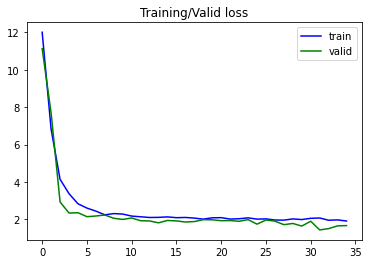

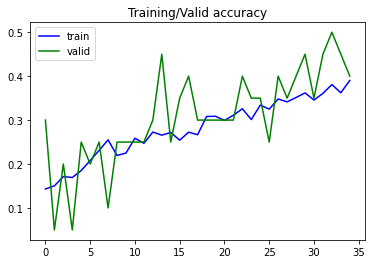

The model has 5,362,394 trainable parameters


In [30]:
EPOCHS = 35
learning_rate = 0.003
loss_function = nn.CrossEntropyLoss()
loss_function = loss_function.to(device)
model = ConvNet(num_classes=len(classes)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
main(model, baby_train_iterator, baby_valid_iterator, optimizer, loss_function, device, None, EPOCHS)
print(f'The model has {count_parameters(model):,} trainable parameters')

## Hyperparameter

### Select learning rate and regularization strength

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 2.951 | Train Acc: 20.86%
	 Val. Loss: 1.959 |  Val. Acc: 35.00%
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.208 | Train Acc: 29.67%
	 Val. Loss: 1.829 |  Val. Acc: 35.00%
Epoch: 15 | Epoch Time: 0m 0s
	Train Loss: 2.012 | Train Acc: 32.68%
	 Val. Loss: 1.835 |  Val. Acc: 35.00%
Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 1.936 | Train Acc: 34.89%
	 Val. Loss: 1.794 |  Val. Acc: 35.00%
Epoch: 25 | Epoch Time: 0m 0s
	Train Loss: 1.809 | Train Acc: 38.01%
	 Val. Loss: 1.724 |  Val. Acc: 40.00%
Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 1.817 | Train Acc: 38.26%
	 Val. Loss: 1.815 |  Val. Acc: 35.00%
Epoch: 35 | Epoch Time: 0m 0s
	Train Loss: 1.781 | Train Acc: 39.64%
	 Val. Loss: 1.736 |  Val. Acc: 50.00%


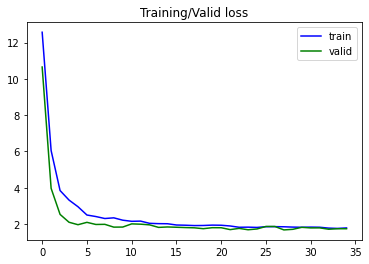

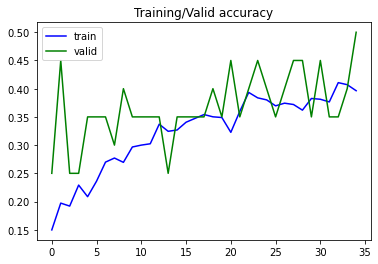

In [31]:
EPOCHS = 35
learning_rate = 0.003
loss_function = nn.CrossEntropyLoss()
loss_function = loss_function.to(device)
model = ConvNet(num_classes=len(classes)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0.003)
main(model, baby_train_iterator, baby_valid_iterator, optimizer, loss_function, device, None, EPOCHS)

#### The best learning rate is 0.003 and the best regularization strength is 0.003

### Select the optimizer

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 9.768 | Train Acc: 18.82%
	 Val. Loss: 2.717 |  Val. Acc: 15.00%
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 3.626 | Train Acc: 21.60%
	 Val. Loss: 2.027 |  Val. Acc: 40.00%
Epoch: 15 | Epoch Time: 0m 0s
	Train Loss: 2.563 | Train Acc: 24.89%
	 Val. Loss: 1.984 |  Val. Acc: 40.00%
Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 2.291 | Train Acc: 27.60%
	 Val. Loss: 1.900 |  Val. Acc: 45.00%
Epoch: 25 | Epoch Time: 0m 0s
	Train Loss: 2.092 | Train Acc: 31.01%
	 Val. Loss: 1.855 |  Val. Acc: 40.00%
Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 2.079 | Train Acc: 30.86%
	 Val. Loss: 1.866 |  Val. Acc: 30.00%
Epoch: 35 | Epoch Time: 0m 0s
	Train Loss: 2.038 | Train Acc: 32.04%
	 Val. Loss: 1.888 |  Val. Acc: 40.00%


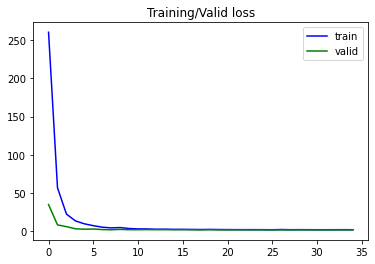

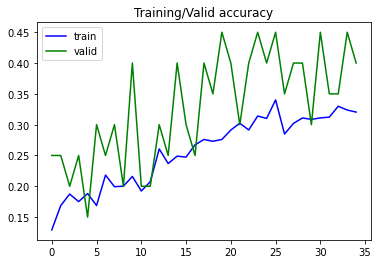

In [32]:
EPOCHS = 35
learning_rate = 0.003
loss_function = nn.CrossEntropyLoss()
loss_function = loss_function.to(device)
model = ConvNet(num_classes=len(classes)).to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=0.003)
main(model, baby_train_iterator, baby_valid_iterator, optimizer, loss_function, device, None, EPOCHS)

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 2.041 | Train Acc: 31.54%
	 Val. Loss: 2.172 |  Val. Acc: 45.00%
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 1.855 | Train Acc: 37.08%
	 Val. Loss: 1.811 |  Val. Acc: 45.00%
Epoch: 15 | Epoch Time: 0m 0s
	Train Loss: 1.791 | Train Acc: 39.64%
	 Val. Loss: 1.693 |  Val. Acc: 40.00%
Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 1.680 | Train Acc: 44.94%
	 Val. Loss: 1.616 |  Val. Acc: 45.00%
Epoch: 25 | Epoch Time: 0m 0s
	Train Loss: 1.603 | Train Acc: 47.96%
	 Val. Loss: 1.514 |  Val. Acc: 40.00%
Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 1.544 | Train Acc: 48.35%
	 Val. Loss: 1.476 |  Val. Acc: 45.00%
Epoch: 35 | Epoch Time: 0m 0s
	Train Loss: 1.498 | Train Acc: 50.56%
	 Val. Loss: 1.390 |  Val. Acc: 45.00%


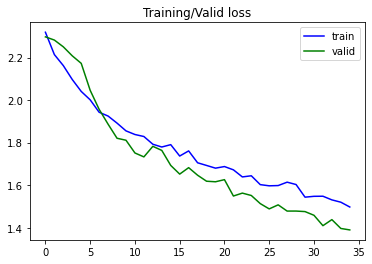

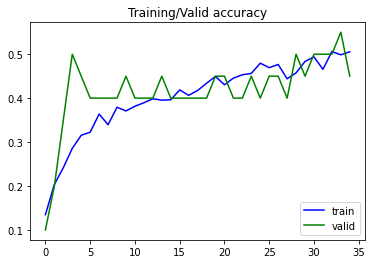

In [33]:
EPOCHS = 35
learning_rate = 0.003
loss_function = nn.CrossEntropyLoss()
loss_function = loss_function.to(device)
model = ConvNet(num_classes=len(classes)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.003)
main(model, baby_train_iterator, baby_valid_iterator, optimizer, loss_function, device, None, EPOCHS)

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 2.415 | Train Acc: 25.96%
	 Val. Loss: 1.897 |  Val. Acc: 25.00%
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 2.114 | Train Acc: 34.85%
	 Val. Loss: 1.791 |  Val. Acc: 40.00%
Epoch: 15 | Epoch Time: 0m 0s
	Train Loss: 1.857 | Train Acc: 39.65%
	 Val. Loss: 1.458 |  Val. Acc: 55.00%
Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 1.736 | Train Acc: 44.72%
	 Val. Loss: 1.515 |  Val. Acc: 45.00%
Epoch: 25 | Epoch Time: 0m 0s
	Train Loss: 1.611 | Train Acc: 48.10%
	 Val. Loss: 1.341 |  Val. Acc: 50.00%
Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 1.602 | Train Acc: 46.49%
	 Val. Loss: 1.340 |  Val. Acc: 50.00%
Epoch: 35 | Epoch Time: 0m 0s
	Train Loss: 1.501 | Train Acc: 46.31%
	 Val. Loss: 1.232 |  Val. Acc: 50.00%


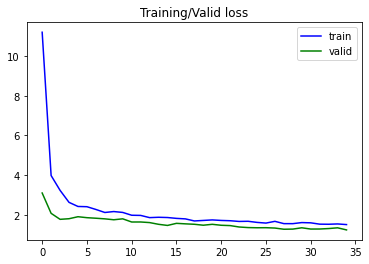

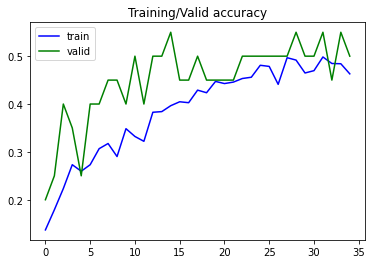

In [34]:
EPOCHS = 35
learning_rate = 0.003
loss_function = nn.CrossEntropyLoss()
loss_function = loss_function.to(device)
model = ConvNet(num_classes=len(classes)).to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=0.003)
main(model, baby_train_iterator, baby_valid_iterator, optimizer, loss_function, device, None, EPOCHS)

#### The best optimizer is Adagrad 

### Examining the Model

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 2.053 | Train Acc: 36.51%
	 Val. Loss: 1.773 |  Val. Acc: 35.00%
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 1.646 | Train Acc: 46.69%
	 Val. Loss: 1.695 |  Val. Acc: 35.00%
Epoch: 15 | Epoch Time: 0m 0s
	Train Loss: 1.531 | Train Acc: 48.81%
	 Val. Loss: 1.323 |  Val. Acc: 55.00%
Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 1.475 | Train Acc: 51.58%
	 Val. Loss: 1.358 |  Val. Acc: 60.00%
Epoch: 25 | Epoch Time: 0m 0s
	Train Loss: 1.352 | Train Acc: 54.62%
	 Val. Loss: 1.376 |  Val. Acc: 65.00%
Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 1.325 | Train Acc: 56.78%
	 Val. Loss: 1.171 |  Val. Acc: 70.00%
Epoch: 35 | Epoch Time: 0m 0s
	Train Loss: 1.243 | Train Acc: 59.31%
	 Val. Loss: 1.184 |  Val. Acc: 70.00%


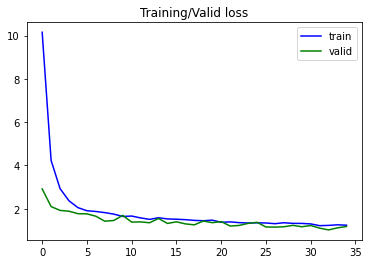

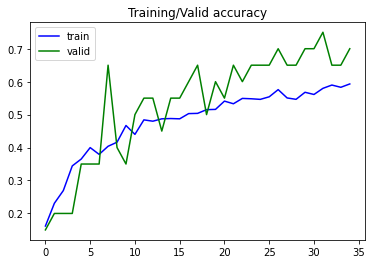

In [35]:
EPOCHS = 35
learning_rate = 0.003
loss_function = nn.CrossEntropyLoss()
loss_function = loss_function.to(device)
model = ConvNet(num_classes=len(classes)).to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=0.003)
main(model, baby_train_iterator, baby_valid_iterator, optimizer, loss_function, device, None, EPOCHS)

In [36]:
#set paths 
baby_testing_dataset_path = "./HW3_Data/HW4_Data/classification_data/baby_test_data"

In [37]:
baby_test_dataset = datasets.ImageFolder(root = baby_testing_dataset_path, transform = testing_transforms)

In [38]:
BATCH_SIZE = 100

baby_test_iterator = data.DataLoader(baby_test_dataset, 
                                 batch_size = BATCH_SIZE,
                                 shuffle = True
                                 )



In [39]:
test_loss, test_acc = evaluate(model, baby_test_iterator, loss_function, device)

In [40]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.402 | Test Acc: 60.00%


# Transfer Learning

In [41]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [42]:
#set paths 
baby_training_dataset_path = "./HW3_Data/HW4_Data/classification_data/baby_train_data"
baby_validation_dataset_path = "./HW3_Data/HW4_Data/classification_data/baby_val_data"
baby_testing_dataset_path = "./HW3_Data/HW4_Data/classification_data/baby_test_data"

In [43]:
root = pathlib.Path(baby_training_dataset_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes[:10], len(classes))

['n000003', 'n000010', 'n000011', 'n000013', 'n000015', 'n000017', 'n000018', 'n000020', 'n000023', 'n000024'] 10


In [44]:
baby_train_dataset = datasets.ImageFolder(root = baby_training_dataset_path, transform = training_transforms)
baby_valid_dataset = datasets.ImageFolder(root = baby_validation_dataset_path, transform = testing_transforms)
baby_test_dataset = datasets.ImageFolder(root = baby_testing_dataset_path, transform = testing_transforms)

In [45]:
BATCH_SIZE = 100

baby_train_iterator = data.DataLoader(baby_train_dataset, 
                                 batch_size = BATCH_SIZE,
                                 shuffle = True)

baby_valid_iterator = data.DataLoader(baby_valid_dataset, 
                                 batch_size = BATCH_SIZE,
                                 shuffle = True)

baby_test_iterator = data.DataLoader(baby_test_dataset, 
                                 batch_size = BATCH_SIZE,
                                 shuffle = True)


In [46]:
model_conv = torchvision.models.vgg16(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

model_conv

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [47]:
model_conv.classifier[6] = nn.Linear(4096, len(classes))
model_conv

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 1.382 | Train Acc: 52.72%
	 Val. Loss: 1.837 |  Val. Acc: 35.00%
Epoch: 10 | Epoch Time: 0m 1s
	Train Loss: 1.320 | Train Acc: 55.53%
	 Val. Loss: 1.826 |  Val. Acc: 40.00%
Epoch: 15 | Epoch Time: 0m 1s
	Train Loss: 1.166 | Train Acc: 60.60%
	 Val. Loss: 1.820 |  Val. Acc: 40.00%
Epoch: 20 | Epoch Time: 0m 1s
	Train Loss: 1.129 | Train Acc: 60.79%
	 Val. Loss: 1.844 |  Val. Acc: 40.00%
Epoch: 25 | Epoch Time: 0m 1s
	Train Loss: 1.071 | Train Acc: 61.86%
	 Val. Loss: 1.753 |  Val. Acc: 35.00%
Epoch: 30 | Epoch Time: 0m 1s
	Train Loss: 1.079 | Train Acc: 61.69%
	 Val. Loss: 1.751 |  Val. Acc: 40.00%
Epoch: 35 | Epoch Time: 0m 1s
	Train Loss: 1.095 | Train Acc: 62.18%
	 Val. Loss: 1.793 |  Val. Acc: 35.00%


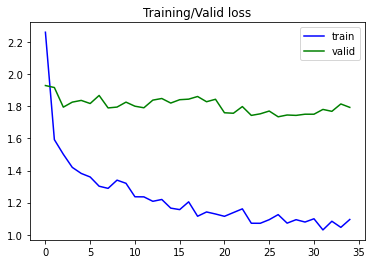

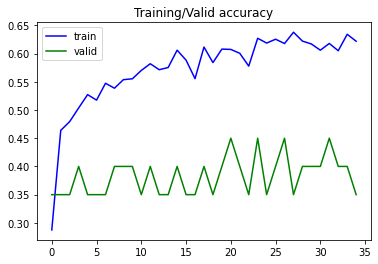

In [48]:
EPOCHS = 35
learning_rate = 0.003
loss_function = nn.CrossEntropyLoss() #contains Softmax
loss_function = loss_function.to(device)

model_conv = model_conv.to(device)
optimizer = torch.optim.Adagrad(model_conv.parameters(), lr=learning_rate, weight_decay=0.003)
main(model_conv, baby_train_iterator, baby_valid_iterator, optimizer, loss_function, device, None, EPOCHS)

In [49]:
test_loss, test_acc = evaluate(model_conv, baby_test_iterator, loss_function, device)

In [50]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.262 | Test Acc: 65.00%
